<a href="https://colab.research.google.com/github/jbarsce/AprendizajePorRefuerzos/blob/master/lab_1_intro_rl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook 1: Introducción al aprendizaje por refuerzos

Curso Aprendizaje por Refuerzos, Diplomatura en Ciencia de Datos, Aprendizaje Automático y sus Aplicaciones

FaMAF, 2023

## Introducción

En el siguiente notebook se muestra cómo ejecutar agentes de aprendizaje por refuerzos, los cuáles son necesarios para realizar este Lab.

### Repaso rápido



* Recompensa: señal $r$ recibida desde el entorno que recompensa o castiga el agente según su desempeño con respecto al objetivo de la tarea.

* Valor: función $v_\pi (s)$ que establece cuánto el agente espera percibir de recompensa al seguir la política $\pi$ partiendo desde el estado $s$. También se la suele expresar como $Q_\pi(s,a)$, indicando cuánto el agente espera percibir siguiendo la política $\pi$ partiendo desde el estado $s$ y siguiendo la acción $a$.

* Política: función $\pi(s) \to a$ que mapea un estado a una acción. Se suele expresar como probabilidad de elegir la acción $\pi(a \mid s)$. La política $\epsilon$-greedy, en donde $\epsilon$ es la probabilidad de exploración (normalmente menor que la probabilidad de explotación) está dada por $\pi(a \mid s) = 1 - \epsilon$ si $a$ es la mejor acción, caso contrario pasa a estar dada por $\pi(a \mid s) = \epsilon$.

Por otra parte, en la política Softmax, no se busca la acción con máxima probabilidad sino que se computa la probabilidad de cada una mediante la función Softmax y se realiza un sorteo entre ellas pesado por la misma. Así, para cada acción $a$, $$\pi(a \mid s) = \frac{e^{Q(s,a)/\tau}}{\sum_{\widetilde{a} \in A}e^{Q(s,\widetilde{a})/\tau}}$$

En este notebook vemos dos algoritmos para actualizar la función de valor (y, por lo tanto, la política de selección de acciones):

* Actualización por SARSA (on-policy).

$$Q(s,a) \gets Q(s,a) + \alpha (r + \gamma Q(s',a') - Q(s,a))$$

Algoritmo completo (a modo de referencia):

![Algoritmo SARSA](https://github.com/DiploDatos/AprendizajePorRefuerzos/blob/master/images/sarsa.png?raw=1)


* Actualización por Q-Learning (off-policy)

$$Q(s,a) \gets Q(s,a) + \alpha (r + \gamma \arg\max_{a'} Q(s',a') - Q(s,a))$$

Algoritmo completo (a modo de referencia):

![Algoritmo Q-Learning](https://github.com/DiploDatos/AprendizajePorRefuerzos/blob/master/images/q_learning.png?raw=1)

Fuente de las imágenes: capítulo 6 de [Reinforcement Learning: An Introduction](http://www.incompleteideas.net/book/the-book.html).

## Librería a usar: Librería OpenAI Gym

[OpenAI Gym](https://gym.openai.com/) (Brockman et. al., 2016) es una librería de OpenAI que ofrece entornos y una interfaz estándar con la cuál probar nuestros agentes. Su objetivo es proveer benchmarks unificados para ver el desempeño de algoritmos en el entorno y así poder saber con facilidad cómo es su desempeño comparado con los demás. Parte de la siguiente sección está basada en la [documentación oficial de OpenAI](https://gym.openai.com/docs/).

La interfaz principal de los ambientes de gym es la interfaz Env. La misma posee cinco métodos principales:

* ```reset(self, seed)``` : Reinicia el estado del entorno, a su estado inicial, devolviendo una observación de dicho estado. Opcionalmente, establece la semilla aleatoria del generador de números aleatorios del presente entorno.

* ```step(self, action)``` : "Avanza" un timestep del ambiente. Devuelve: ```observation, reward, terminated, truncated, info```.

* ```render(self)``` : Muestra en pantalla una parte del ambiente.

* ```close(self)``` : Finaliza con la instancia del agente.


Por otra parte, cada entorno posee los siguientes tres atributos principales:

* ```action_space``` : El objeto de tipo Space correspondiente al espacio de acciones válidas.

* ```observation_space``` : El objeto de tipo Space correspondiente a todos los rangos posibles de observaciones.

* ```reward_range``` : Tupla que contiene los valores mínimo y máximo de recompensa posible.

Algunas de las ejecuciones contienen videos. Para poder verlos se necesita previamente instalar la librería ffmpeg; para instalarla desde Linux ejecutar en consola

```apt-get install ffmpeg```

desde Mac, reemplazar *apt-get* por *brew*

desde Windows, descargarla desde

[https://ffmpeg.org/download.html](https://ffmpeg.org/download.html)

(Nota: las animaciones son a modo ilustrativo, si no se desea instalar la librería se puede directamente eliminar la línea de código donde se llama al método ``env.render(mode='human')``)

Código básico de importación y funciones de graficación (no modificar)

In [1]:
# @title Código básico importacion y utilerías (no modificar)

import itertools
from typing import Any, Callable, Tuple

import numpy as np
import matplotlib.pyplot as plt


def plot_reward_per_episode(reward_ep) -> None:
    episode_rewards = np.array(reward_ep)

    # se suaviza la curva de convergencia
    episode_number = np.linspace(
        1, len(episode_rewards) + 1, len(episode_rewards) + 1)
    acumulated_rewards = np.cumsum(episode_rewards)

    reward_per_episode = [
        acumulated_rewards[i] / episode_number[i]
        for i in range(len(acumulated_rewards))
    ]

    plt.plot(reward_per_episode)
    plt.title("Recompensa acumulada por episodio")
    plt.show()


def plot_steps_per_episode(timesteps_ep) -> None:
    # se muestra la curva de aprendizaje de los pasos por episodio
    episode_steps = np.array(timesteps_ep)
    plt.plot(np.array(range(0, len(episode_steps))), episode_steps)
    plt.title("Pasos (timesteps) por episodio")
    plt.show()


def plot_steps_per_episode_smooth(timesteps_ep) -> None:
    episode_steps = np.array(timesteps_ep)

    # se suaviza la curva de aprendizaje
    episode_number = np.linspace(
        1, len(episode_steps) + 1, len(episode_steps) + 1)
    acumulated_steps = np.cumsum(episode_steps)

    steps_per_episode = [
        acumulated_steps[i] / episode_number[i] for i in range(
            len(acumulated_steps))
    ]

    plt.plot(steps_per_episode)
    plt.title("Pasos (timesteps) acumulados por episodio")
    plt.show()


def draw_value_matrix(q) -> None:
    n_rows = 4
    n_columns = 12
    n_actions = 4

    # se procede con los cálculos previos a la graficación de la matriz de valor
    q_value_matrix = np.empty((n_rows, n_columns))
    for row in range(n_rows):
        for column in range(n_columns):
            state_values = []

            for action in range(n_actions):
                state_values.append(
                    q.get((row * n_columns + column, action), -100))

            maximum_value = max(
                state_values
            )  # determinamos la acción que arroja máximo valor

            q_value_matrix[row, column] = maximum_value

    # el valor del estado objetivo se asigna en -1 (reward recibido al llegar)
    # para que se coloree de forma apropiada
    q_value_matrix[3, 11] = -1

    # se grafica la matriz de valor
    plt.imshow(q_value_matrix, cmap=plt.cm.RdYlGn)
    plt.tight_layout()
    plt.colorbar()

    for row, column in itertools.product(
        range(q_value_matrix.shape[0]), range(q_value_matrix.shape[1])
    ):
        left_action = q.get((row * n_columns + column, 3), -1000)
        down_action = q.get((row * n_columns + column, 2), -1000)
        right_action = q.get((row * n_columns + column, 1), -1000)
        up_action = q.get((row * n_columns + column, 0), -1000)

        arrow_direction = "D"
        best_action = down_action

        if best_action < right_action:
            arrow_direction = "R"
            best_action = right_action
        if best_action < left_action:
            arrow_direction = "L"
            best_action = left_action
        if best_action < up_action:
            arrow_direction = "U"
            best_action = up_action
        if best_action == -1:
            arrow_direction = ""

        # notar que column, row están invertidos en orden en la línea de abajo
        # porque representan a x,y del plot
        plt.text(column, row, arrow_direction, horizontalalignment="center")

    plt.xticks([])
    plt.yticks([])
    plt.show()

    print("\n Matriz de mejor acción-valor (en números): \n\n", q_value_matrix)

Ejemplo: agente CartPole

In [2]:
from IPython.display import clear_output
#!pip install gymnasium

try:
  import google.colab
  IN_COLAB = True

  !pip install gymnasium

except:
  IN_COLAB = False

import gymnasium as gym

# no es posible mostrar videos de ejecución del agente desde Colab
if not IN_COLAB:

    env = gym.make('CartPole-v0')
    env.reset()
    env.render()

    for _ in range(500):
        env.render()
        # se ejecuta una acción aleatoria
        obs, reward, terminated, truncated, info = env.step(
           env.action_space.sample())

        done = terminated or truncated
        if done:
            env.reset()
    env.close()
    clear_output()

Ejemplo: agente Mountain Car

In [3]:
if not IN_COLAB:
    env = gym.make('MountainCar-v0')
    obs = env.reset()
    for t in range(500):
        env.render()
        action = env.action_space.sample()
        obs, reward, terminated, truncated, info = env.step(action)
        if done:
            print("Episode finished after {} timesteps".format(t+1))
            break
    env.close()
    clear_output()

## Ejemplo 1: The Cliff.


![](https://github.com/GIDISIA/RLDiplodatos/blob/master/images/cliffwalking.png?raw=1)

donde S= starting point, G= goal

(imagen de Sutton y Barto, 2018)

Descripción del entorno:

Acciones:

* $\uparrow$ - Arriba
* $\downarrow$ - Abajo
* $\rightarrow$ - Derecha
* $\leftarrow$ - Izquierda

Función de recompensa:

* $-1$ en todos los demás estados
* $-100$ en el acantilado

Nota: caer en el acantilado devuelve al agente al estado inicial en un mismo episodio

Vemos los bloques básicos de nuestro agente

Definimos el método de elección de acciones. En este caso el mismo utiliza la política de exploración $\epsilon$-greedy.

In [4]:
def choose_action_e_greedy(
        state: int,
        actions: range,
        q: dict,
        hyperparameters: dict,
        random_state: np.random.RandomState,
) -> int:
    """
    Elije una acción de acuerdo al aprendizaje realizado previamente
    usando una política de exploración épsilon-greedy
    """
    # ej: para 4 acciones inicializa en [0,0,0,0]
    q_values = [q.get((state, a), 0.0) for a in actions]
    max_q = max(q_values)
    # sorteamos un número: es menor a épsilon?
    if random_state.uniform() < hyperparameters['epsilon']:
        # sí: se selecciona una acción aleatoria
        return random_state.choice(actions)

    count = q_values.count(max_q)

    # hay más de un máximo valor de estado-acción?
    if count > 1:
        # sí: seleccionamos uno de ellos aleatoriamente
        best = [i for i in range(len(actions)) if q_values[i] == max_q]
        i = random_state.choice(best)
    else:
        # no: seleccionamos el máximo valor de estado-acción
        i = q_values.index(max_q)

    return actions[i]

Definimos el esqueleto del método learn, el cuál toma una transición y cambia el dict de los valores de Q de acuerdo a algún algoritmo.

In [5]:
# @title algoritmo SARSA
from typing import Any, Dict, Tuple

def learn_SARSA(
    state: int,
    action: int,
    reward: float,
    next_state: int,
    next_action: int,
    hyperparameters: Dict[str, float],
    q: Dict[Tuple[int, int], float]
) -> None:
    """
    Realiza una actualización según el algoritmo SARSA, para una transición
    de estado dada
    Args:
        state: Estado actual
        action: Acción actual
        reward: Recompensa observada
        next_state: Siguiente estado
        next_action: Siguiente acción
        hyperparameters: Hiperparámetros del algoritmo (alpha y gamma)
        q: Tabla Q que almacena los valores de estado-acción
    """

    # Obtén los hiperparámetros relevantes
    alpha = hyperparameters['alpha']
    gamma = hyperparameters['gamma']

    # Obtén los valores Q para el estado actual y siguiente estado
    q_current = q.get((state, action), 0.0)
    q_next = q.get((next_state, next_action), 0.0)

    # Calcula el objetivo de SARSA (TD target)
    td_target = reward + gamma * q_next

    # Actualiza el valor Q para el estado-acción actual
    q[(state, action)] = q_current + alpha * (td_target - q_current)

# Define las variables con valores apropiados antes de llamar a la función learn_SARSA
state = 1  # Define el estado actual
action = 2  # Define la acción actual
reward = -1.0  # Define la recompensa observada
next_state = 3  # Define el siguiente estado
next_action = 4  # Define la siguiente acción
hyperparameters = {
    'alpha': 0.5,  # Define el valor de alpha
    'gamma': 0.9,  # Define el valor de gamma
}
q = {}  # Define tu tabla Q (por ejemplo, un diccionario)

# Llama a la función para realizar la actualización SARSA
learn_SARSA(state, action, reward, next_state, next_action, hyperparameters, q)


In [6]:
# @title algoritmo Q-Learning
def learn_Q_learning(
    state: int,
    action: int,
    reward: float,
    next_state: int,
    hyperparameters: Dict[str, float],
    q: Dict[Tuple[int, int], float]
) -> None:
    """
    Realiza una actualización según el algoritmo Q-learning, para una transición
    de estado dada
    Args:
        state: Estado actual
        action: Acción actual
        reward: Recompensa observada
        next_state: Siguiente estado
        hyperparameters: Hiperparámetros del algoritmo (alpha y gamma)
        q: Tabla Q que almacena los valores de estado-acción
    """

    # Obtén los hiperparámetros relevantes
    alpha = hyperparameters['alpha']
    gamma = hyperparameters['gamma']

    # Obtén el valor Q máximo para el siguiente estado
    q_max_next = max(q.get((next_state, a), 0.0) for a in actions)

    # Calcula el objetivo de Q-learning (TD target)
    td_target = reward + gamma * q_max_next

    # Obtén el valor Q actual para el estado-acción actual
    q_current = q.get((state, action), 0.0)

    # Actualiza el valor Q para el estado-acción actual
    q[(state, action)] = q_current + alpha * (td_target - q_current)

Finalmente, definimos el método principal de iteraciones.

In [7]:
#Funcion run (modificada con respecto a la original)
import gymnasium as gym

from typing import Callable, Dict, Tuple

import numpy as np

def run(
    learning_function: Callable,
    hyperparameters: Dict[str, float],
    episodes_to_run: int,
    env: gym.Env,
    actions: range,
    q: Dict[Tuple[int, int], float],
    random_state: np.random.RandomState,
    use_next_action: bool = False
) -> Tuple[float, np.ndarray, np.ndarray]:
    timesteps_of_episode = []
    reward_of_episode = []

    for _ in range(episodes_to_run):
        state, _ = env.reset()
        episode_reward = 0
        done = False
        t = 0

        action = choose_action_e_greedy(
            state, actions, q, hyperparameters, random_state)

        while not done:
            next_state, reward, terminated, truncated, _ = env.step(action)

            if use_next_action:
                next_action = choose_action_e_greedy(
                    next_state, actions, q, hyperparameters, random_state)
                learning_function(
                    state, action, reward, next_state, next_action, hyperparameters, q)
            else:
                learning_function(
                    state, action, reward, next_state, hyperparameters, q)

            episode_reward += reward
            done = terminated or truncated

            if not done and t < 2000:
                state = next_state
                action = next_action if use_next_action else choose_action_e_greedy(
                    next_state, actions, q, hyperparameters, random_state)
            else:
                done = True
                timesteps_of_episode = np.append(timesteps_of_episode, [int(t + 1)])
                reward_of_episode = np.append(
                    reward_of_episode, max(episode_reward, -100)
                )

            t += 1

    return reward_of_episode.mean(), timesteps_of_episode, reward_of_episode


Definidos los métodos básicos, procedemos a instanciar a nuestro agente.

In [8]:
# se crea el diccionario que contendrá los valores de Q
# para cada tupla (estado, acción)
q = {}

# definimos sus híper-parámetros básicos
hyperparameters = {
    "alpha": 0.5,
    "gamma": 1,
    "epsilon": 0.1,
    "tau": 25,
}


# se puede cambiar por learn_Q_learning, una vez que se implemente
learning_function = learn_SARSA #NO FUNCIONA CON Q-LEARNING
episodes_to_run = 500

env = gym.make("CliffWalking-v0")
actions = range(env.action_space.n)

# se declara una semilla aleatoria
random_state = np.random.RandomState(42)

Ya instanciado, ejecutamos nuestro agente

In [9]:
#probar esto para SARSA
# Hiperparámetros para SARSA
hyperparameters_sarsa = {
    'alpha': 0.5, 
    'gamma': 0.9,  
    'epsilon': 0.1
}
# Tabla Q para SARSA
q_sarsa = {}

avg_steps_per_episode_sarsa, timesteps_ep_sarsa, reward_ep_sarsa = run(
    learning_function=learn_SARSA,
    hyperparameters=hyperparameters_sarsa,
    episodes_to_run=episodes_to_run,
    env=env,
    actions=actions,
    q=q_sarsa,
    random_state=random_state,
    use_next_action=True  # SARSA necesita el argumento next_action
)


In [10]:
#probar esto para Q-learning
# Hiperparámetros para Q-learning
hyperparameters_q_learning = {
    'alpha': 0.5,
    'gamma': 0.9,
    'epsilon': 0.1
}
# Tabla Q para Q-learning
q_q_learning = {}
avg_steps_per_episode_q_learning, timesteps_ep_q_learning, reward_ep_q_learning = run(
    learning_function=learn_Q_learning,
    hyperparameters=hyperparameters_q_learning,
    episodes_to_run=episodes_to_run,
    env=env,
    actions=actions,
    q=q_q_learning,
    random_state=random_state,
    use_next_action=False  # Q-learning no necesita el argumento next_action
)


### Análisis de la ejecución del agente

#### Análisis de convergencia

A diferencia de lo que sucede en el aprendizaje supervisado, en el aprendizaje por refuerzos el rendimiento se evalúa por una función específica que es la función de recompensa. En la práctica, la función de recompensa puede ser externa (y provista por el entorno) o bien puede ser una función creada por diseño (a modo de dirigir el agente hacia lo que por diseño se considera mejor, en nuestro ejemplo podría ser con una recompensa de $+1$ cada vez que el agente llega al estado objetivo). Esto se conoce como *reward shaping*, y hay que tener mucho cuidado con los posibles efectos secundarios de su uso.

Como el objetivo de RL es maximizar la recompensa obtenida, es posible utilizar la información sobre la obtención de la recompensas en cada time-step o episodio para evaluar el rendimiento parcial del agente (esto depende mucho de la particularidad de la distribución de la recompensa para el problema tratado).

Para analizar la ejecución del agente, vamos a ver cómo se desempeñó el mismo en dos curvas:

* Recompensa obtenida en cada episodio: nos dirá cuánta recompensa obtuvo el agente sumando cada una de recompensas individuales de cada episodio. Con esta medida podremos tener una noción de cómo se desempeñó esquivando el acantilado y llegando lo antes posible a la meta.

* Pasos transcurridos en cada episodio: indicará cuántos pasos le ha llevado al agente la ejecución del episodio.

Se estila suavizar ambas curvas para apreciar mejor su progresión (aunque a veces suele analizarse la curva de pasos por episodio sin suavizar).

Veamos recompensa por episodio (recordar que en este entorno cada paso otorga una recompensa de $-1$ excepto al caer al acantilado, donde la recompensa es de $-100$)

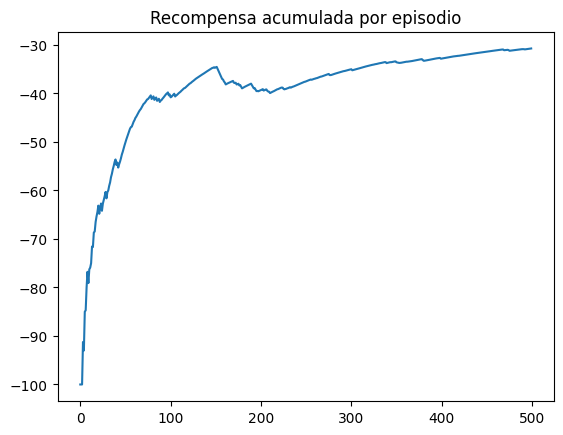

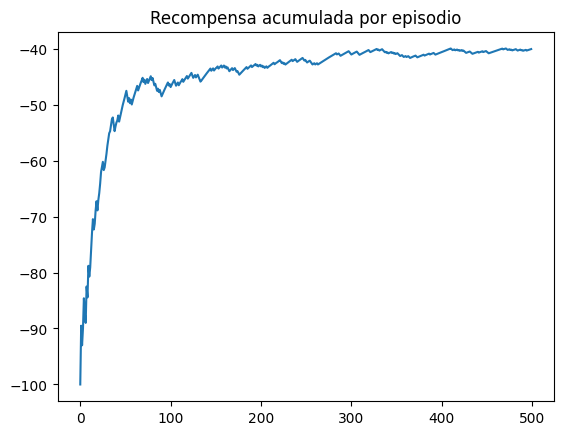

In [11]:
plot_reward_per_episode(reward_ep_sarsa)
plot_reward_per_episode(reward_ep_q_learning)

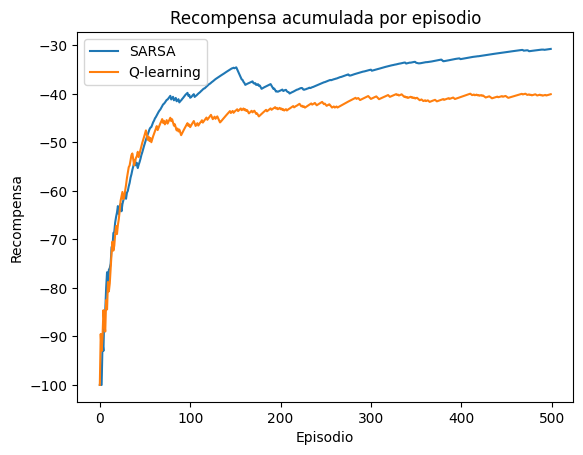

In [12]:
import matplotlib.pyplot as plt
import numpy as np

def plot_reward_per_episode_together(reward_ep_sarsa, reward_ep_q_learning):
    def smooth_rewards(reward_ep):
        episode_rewards = np.array(reward_ep)
        episode_number = np.linspace(
            1, len(episode_rewards) + 1, len(episode_rewards) + 1)
        accumulated_rewards = np.cumsum(episode_rewards)
        return [accumulated_rewards[i] / episode_number[i] for i in range(len(accumulated_rewards))]

    sarsa_smoothed = smooth_rewards(reward_ep_sarsa)
    q_learning_smoothed = smooth_rewards(reward_ep_q_learning)

    plt.plot(sarsa_smoothed, label="SARSA")
    plt.plot(q_learning_smoothed, label="Q-learning")

    plt.title("Recompensa acumulada por episodio")
    plt.xlabel("Episodio")
    plt.ylabel("Recompensa")
    plt.legend()
    plt.show()

# Luego puedes usar la función así:
plot_reward_per_episode_together(reward_ep_sarsa, reward_ep_q_learning)


Veamos pasos por episodio

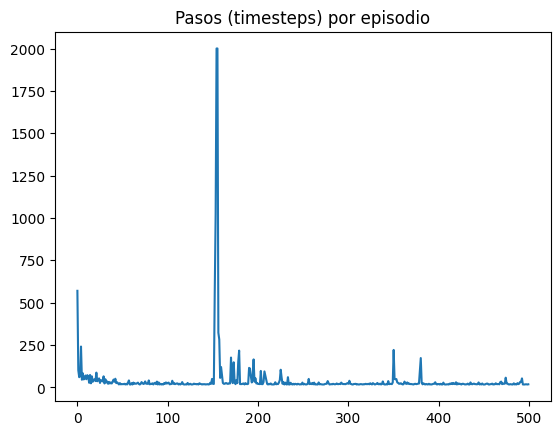

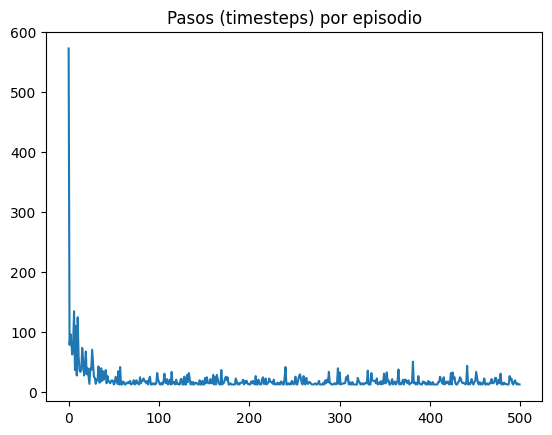

In [13]:
plot_steps_per_episode(timesteps_ep_sarsa)
plot_steps_per_episode(timesteps_ep_q_learning)

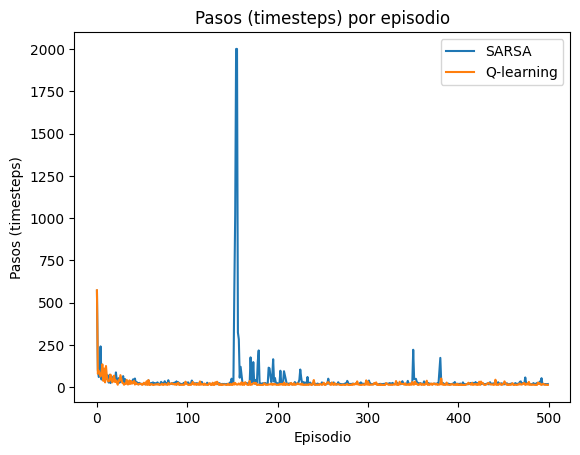

In [14]:
def plot_steps_per_episode_together(timesteps_ep_sarsa, timesteps_ep_q_learning):
    plt.plot(timesteps_ep_sarsa, label="SARSA")
    plt.plot(timesteps_ep_q_learning, label="Q-learning")

    plt.title("Pasos (timesteps) por episodio")
    plt.xlabel("Episodio")
    plt.ylabel("Pasos (timesteps)")
    plt.legend()
    plt.show()

plot_steps_per_episode_together(timesteps_ep_sarsa, timesteps_ep_q_learning)

Suavizando...

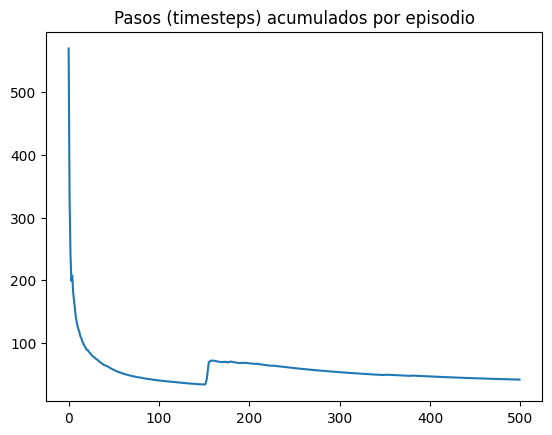

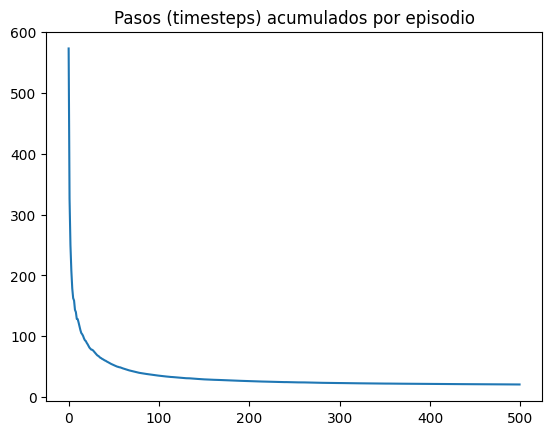

In [15]:
plot_steps_per_episode_smooth(timesteps_ep_sarsa)
plot_steps_per_episode_smooth(timesteps_ep_q_learning)

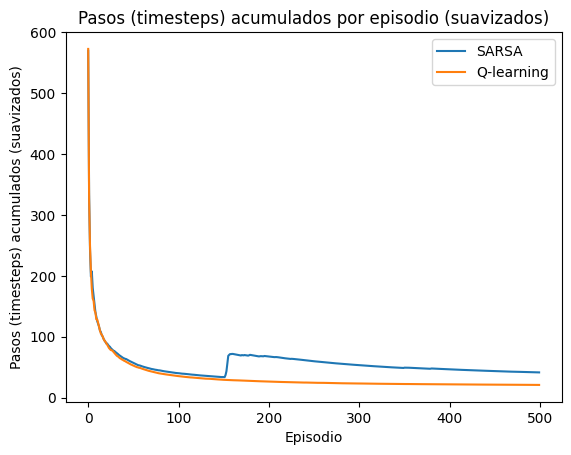

In [16]:
import matplotlib.pyplot as plt
import numpy as np

def plot_steps_per_episode_smooth_together(timesteps_ep_sarsa, timesteps_ep_q_learning):
    def smooth_curve(timesteps_ep):
        episode_steps = np.array(timesteps_ep)
        episode_number = np.linspace(1, len(episode_steps) + 1, len(episode_steps) + 1)
        acumulated_steps = np.cumsum(episode_steps)
        steps_per_episode = [acumulated_steps[i] / episode_number[i] for i in range(len(acumulated_steps))]
        return steps_per_episode

    smoothed_sarsa = smooth_curve(timesteps_ep_sarsa)
    smoothed_q_learning = smooth_curve(timesteps_ep_q_learning)

    plt.plot(smoothed_sarsa, label="SARSA")
    plt.plot(smoothed_q_learning, label="Q-learning")

    plt.title("Pasos (timesteps) acumulados por episodio (suavizados)")
    plt.xlabel("Episodio")
    plt.ylabel("Pasos (timesteps) acumulados (suavizados)")
    plt.legend()
    plt.show()

plot_steps_per_episode_smooth_together(timesteps_ep_sarsa, timesteps_ep_q_learning)


#### Análisis de matriz de acción-valor y política óptima

Siendo que este es un ejemplo tabular y de pocos estados / acciones, es posible realizar un análisis de convergencia desde otro punto de vista: desde el valor de la función $Q(s,a)$ para la mejor acción de cada estado, al finalizar el entrenamiento del agente, (sería la acción que el agente ejecutaría en cada estado bajo una política *greedy*). Ambos nos brindarán información sobre la convergencia alcanzada por el agente.

Tener en cuenta que este análisis se hace principalmente con fines educativos, para entornos más complejos el mismo puede no ser factible. En tales casos, un análisis alternativo podría consistir en hacer que el agente ejecute su política para la que fue entrenado, para hacer una evaluación a partir del comportamiento del mismo (esto último sería el *test de la política*, frente al *entrenamiento de la política* previo).

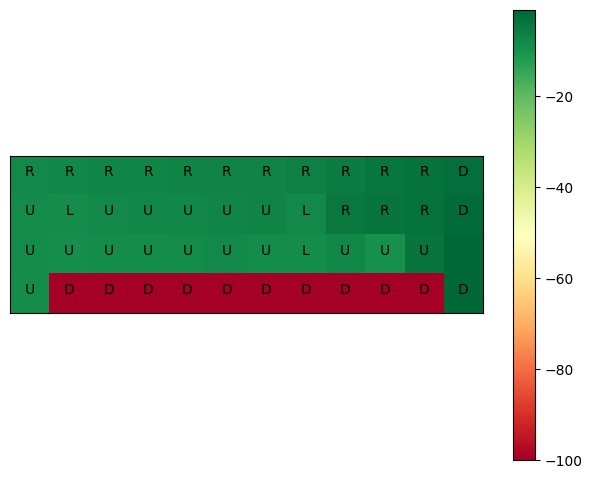


 Matriz de mejor acción-valor (en números): 

 [[  -8.09915993   -7.79813286   -7.51927293   -7.31157512   -7.15500301
    -6.98221287   -7.10058065   -6.3303956    -5.39501416   -4.38253103
    -3.53746464   -2.72656992]
 [  -8.37520072   -8.81020429   -8.19073549   -7.62325487   -7.71565019
    -7.50796094   -6.81907389   -8.05698196   -4.70528898   -3.90469458
    -2.95804277   -1.90019246]
 [  -8.7304137    -9.22505676   -9.04753721   -8.86867489   -8.63536761
    -8.32668616   -8.5508939    -8.76884126   -7.86903212   -9.78222744
    -4.02887184   -1.        ]
 [  -9.03710791 -100.         -100.         -100.         -100.
  -100.         -100.         -100.         -100.         -100.
  -100.           -1.        ]]


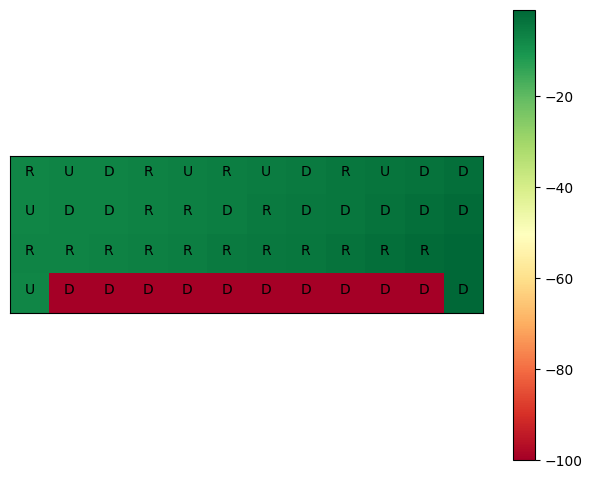


 Matriz de mejor acción-valor (en números): 

 [[  -7.30321559   -7.029416     -6.80869232   -6.55149991   -6.20535527
    -5.82917913   -5.41094579   -4.95656722   -4.46486699   -3.88270977
    -3.332171     -2.70430523]
 [  -7.40266424   -7.17122946   -6.86069109   -6.51304103   -6.12573685
    -5.69529697   -5.21702236   -4.68558677   -4.09509898   -3.43899958
    -2.70999991   -1.9       ]
 [  -7.17570464   -6.86189404   -6.5132156    -6.12579511   -5.6953279
    -5.217031     -4.68559      -4.0951       -3.439        -2.71
    -1.9          -1.        ]
 [  -7.45813417 -100.         -100.         -100.         -100.
  -100.         -100.         -100.         -100.         -100.
  -100.           -1.        ]]


In [17]:
draw_value_matrix(q_sarsa)
draw_value_matrix(q_q_learning)

In [18]:
env.close()

## Actividades

1. Implementar y ejecutar el algoritmo SARSA en "The Cliff".

2. Implementar y ejecutar el algoritmo Q-Learning en "The Cliff". ¿Cómo converge con respecto a SARSA? ¿A qué se debe? Comentar.

3. Ejecutando con distintos híper-parámetros, realizar una breve descripción sobre cómo afectan a la convergencia los distintos valores de $\alpha$, $\epsilon$ y $\gamma$.

4. (Opcional) Implementar política de exploración Softmax, en donde cada acción tiene una probabilidad $$\pi(a \mid s) = \frac{e^{Q(s,a)/\tau}}{\sum_{\widetilde{a} \in A}e^{Q(s,\widetilde{a})/\tau}}$$

5. (Opcional) Implementar Dyna-Q a partir del algoritmo Q-Learning, incorporando una actualización mediante un modelo. Comentar cómo se desempeña respecto a los demás algoritmos.


Para dejar el lab listo para su corrección, dejar link a repo de Github con un notebook ejecutando el agente en la planilla enviada en Slack.

1. Se puede visualizar en los resultados mas arriba.

2. Q-learning aprende valores para la política óptima, viaja justo al borde del acantilado. Resultando en que ocasionalmente se caiga por el precipicio debido a la acción de $\epsilon$-greedy. SARSA, por otro lado, tiene en cuenta la selección de acciones y aprende el camino más largo pero más seguro a través de la parte superior de la cuadrícula. Aunque Q-learning en realidad aprende los valores de la política óptima, su rendimiento es peor que el de SARSA, el cual llega a la politica óptima de forma indirecta.

3. Efecto de los hiperparámetros en la convergencia:

    - $\alpha$ (tasa de aprendizaje):
    Un valor alto de $\alpha$ puede hacer que el aprendizaje sea inestable y oscile alrededor de los valores óptimos.Un valor bajo de $\alpha$ (cerca de 0.0) hace que el aprendizaje sea más estable pero lento. Converge de manera suave pero podría llevar mucho tiempo alcanzar la política óptima.

    - $\epsilon$ (tasa de exploración):
    Un valor alto de $\epsilon$ hará que el agente explore más. Si es demasiado alto, el agente podría tardar más en converger a una política óptima.
    Un valor bajo de $\epsilon$ hará que el agente explore menos lo que puede ser útil para la explotación. Sin embargo, podría llevar a una convergencia temprana a una política subóptima.

    - $\gamma$ (factor de descuento):
    Un valor alto de $\gamma$ da más peso a las recompensas a largo plazo. Esto puede llevar a una política más enfocada en las recompensas futuras, pero también puede requerir más exploración para encontrar la política óptima.
    Un valor bajo de $\gamma$ se enfoca más en las recompensas inmediatas y puede llevar a una convergencia más rápida, pero con la consecuencia de pasar por alto recompensas futuras.

FIN